## Project: Bike Rental Prediction

### Project Overview

Bike-sharing systems generate large amounts of data that capture how people move around the city. This dataset records environmental factors (temperature, humidity, weather), seasonal factors (season, year, month), time-related variables (weekday, holiday, working day), and the actual bike rental count.

## contents:
- Setup & data load
- EDA (day.csv + hour.csv)
- Preprocessing & feature engineering
- Model training, evaluation & comparison
- Final model selection and export

### This project solves two tasks:

Task 1 — Full Data Analysis Report

You explore the dataset, clean it, analyze patterns, and understand what affects bike rentals.

Task 2 — Predicting Daily Bike Rentals

You train machine-learning models to predict the number of bikes rented on a given day based on environmental and seasonal factors.

## Imports & Setup

In [1]:
#Standard Libraries
import os
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

#Save and Load Model
import pickle
from flask import Flask

## TASK 1 — Data Analysis Report (with day.csv)

In [2]:
#Load the dataset

day = pd.read_csv('day.csv')
print("Rows and Columns in Day dataset:",day.shape)  #shape of dataset
display(day.head())
hour = pd.read_csv('hour.csv')
print("Rows and Columns in Hour Dataset:", hour.shape)
display(hour.head())

Rows and Columns in Day dataset: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Rows and Columns in Hour Dataset: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
# Data Cleaning and Feature engineering

df = hour.copy()           #copy the dataset

#Convert date column from string to actual datatype
df['dteday'] = pd.to_datetime(df['dteday'])

# Extract Year, Month, Weekday from date column
df['Year'] = df['dteday'].dt.year
df['Month'] = df['dteday'].dt.month
df['Week Day'] = df['dteday'].dt.day_name()

# Map Season numbers to labels
season_map = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
df['season_name'] = df['season'].map(season_map)

# Map Whether situations to labels
weather_map = {1: 'clear', 2: 'mist', 3: 'light_rain_snow'}
df['weather_name'] = df['weathersit'].map(weather_map)

#target variable
df['target'] = df['cnt']

df.head()  #updated dataset

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,Year,Month,Week Day,season_name,weather_name,target
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.0,3,13,16,2011,1,Saturday,winter,clear,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.0,8,32,40,2011,1,Saturday,winter,clear,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.0,5,27,32,2011,1,Saturday,winter,clear,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.0,3,10,13,2011,1,Saturday,winter,clear,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.0,0,1,1,2011,1,Saturday,winter,clear,1


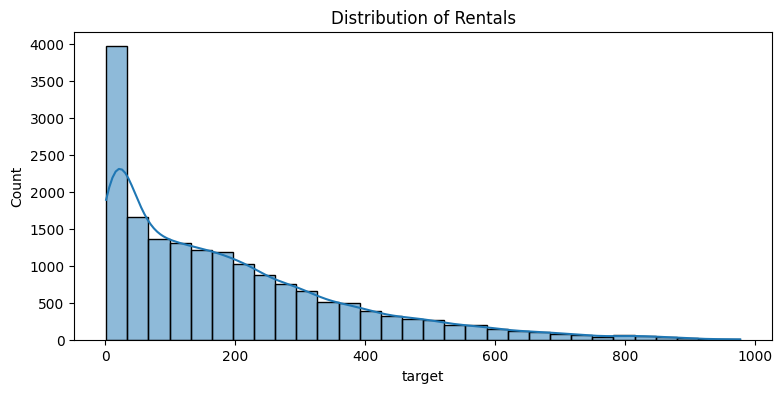

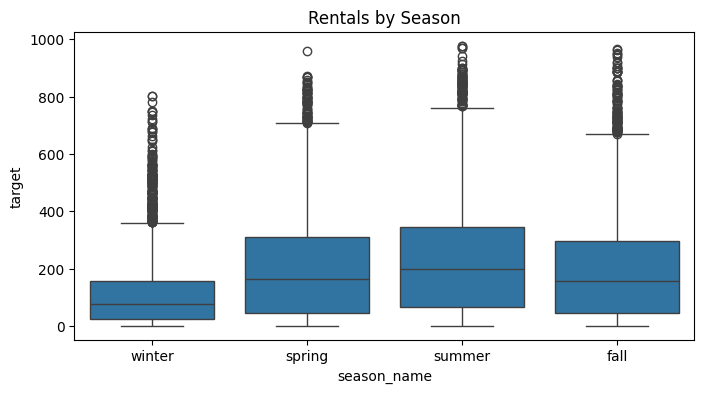

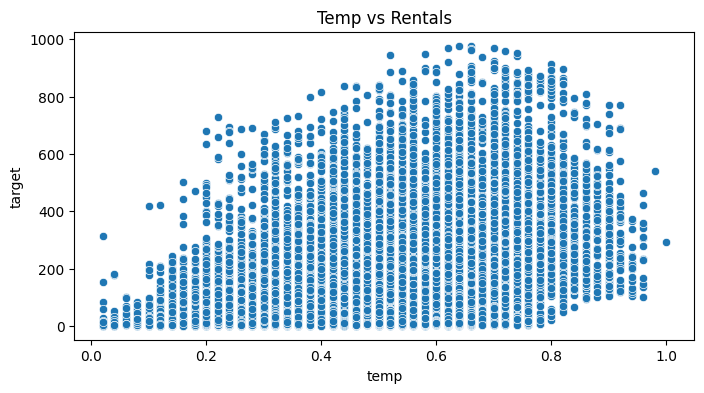

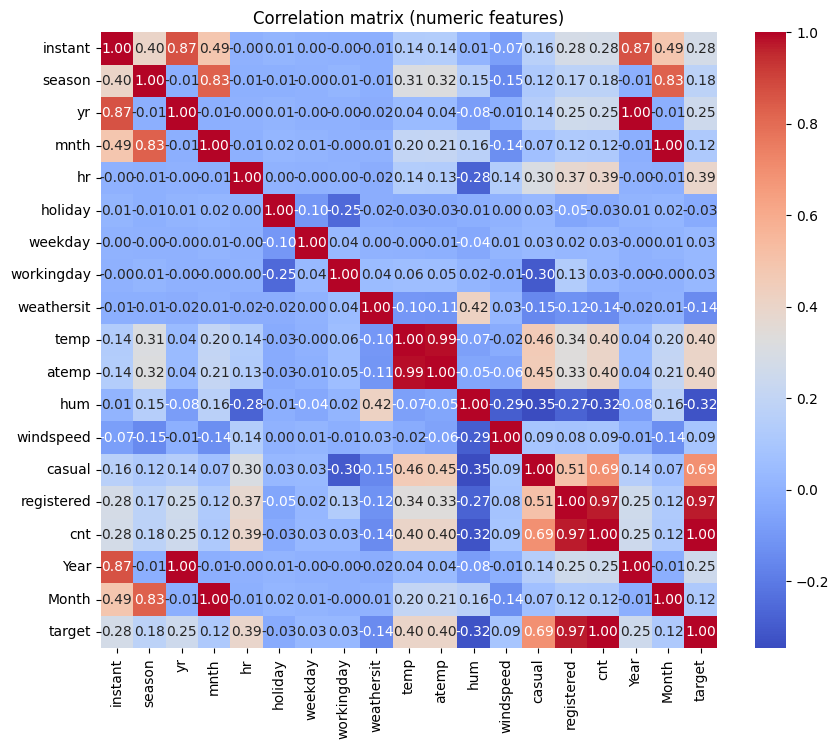

In [5]:
# Exploratory Data Analysis

# Distribution of the target
plt.figure(figsize=(9,4))
sns.histplot(df['target'], bins=30, kde=True)
plt.title('Distribution of Rentals')
plt.show()

# Rentals by season (boxplot)
plt.figure(figsize=(8,4))
order = ['winter','spring','summer','fall']
sns.boxplot(x='season_name', y='target', data=df, order=order)
plt.title('Rentals by Season')
plt.show()

# Temperature vs Rentals scatter
plt.figure(figsize=(8,4))
sns.scatterplot(x='temp', y='target', data=df)
plt.title('Temp vs Rentals')
plt.show()

# Correlation heatmap for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix (numeric features)')
plt.show()

## Task 2 — Predicting Daily Bike Rentals

In [6]:
# Select input and output features

features = ['season','yr','mnth','hr', 'holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed']

X = df[features]
y = df['target']

print('X Shape:', X.shape)

X Shape: (17379, 12)


In [7]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Numerical_cols & Categorical_cols
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']
categorical_cols = [c for c in X.columns if c not in numerical_cols]

In [8]:
# Preprocessing Pipeline

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## Training the Models and Calculating the metrics

In [9]:
print("---- Linear Regression ----")

lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print("MAE :", lr_mae)
print("MSE :", lr_mse)
print("RMSE:", lr_rmse)
print("R2  :", lr_r2)

---- Linear Regression ----
MAE : 74.10514213143131
MSE : 10089.384917254809
RMSE: 100.44593031703579
R2  : 0.6813752137923819


In [10]:
from sklearn.tree import DecisionTreeRegressor

print("---- Decision Tree ----")

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

dt_pipe.fit(X_train, y_train)
dt_pred = dt_pipe.predict(X_test)

dt_mae = mean_absolute_error(y_test, dt_pred)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_pred)

print("MAE :", dt_mae)
print("MSE :", dt_mse)
print("RMSE:", dt_rmse)
print("R2  :", dt_r2)


---- Decision Tree ----
MAE : 39.95296317606444
MSE : 4356.995468929805
RMSE: 66.00754100047816
R2  : 0.8624052148688324


In [12]:
from sklearn.ensemble import RandomForestRegressor

print("---- Random Forest ----")

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_estimators=200))
])

rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("MAE :", rf_mae)
print("MSE :", rf_mse)
print("RMSE:", rf_rmse)
print("R2  :", rf_r2)

---- Random Forest ----
MAE : 29.509791810510166
MSE : 2236.589632876966
RMSE: 47.29259596254963
R2  : 0.9293680537065389


In [13]:
from sklearn.svm import SVR

print("---- Support Vector Machine ----")

svm_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", SVR())
])

svm_pipe.fit(X_train, y_train)
svm_pred = svm_pipe.predict(X_test)

svm_mae = mean_absolute_error(y_test, svm_pred)
svm_mse = mean_squared_error(y_test, svm_pred)
svm_rmse = np.sqrt(svm_mse)
svm_r2 = r2_score(y_test, svm_pred)

print("MAE :", svm_mae)
print("MSE :", svm_mse)
print("RMSE:", svm_rmse)
print("R2  :", svm_r2)

---- Support Vector Machine ----
MAE : 92.11373340254184
MSE : 19075.544748057204
RMSE: 138.11424527563116
R2  : 0.3975904956555758


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

print("---- Gradient Boosting ----")

gb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_pipe.fit(X_train, y_train)
gb_pred = gb_pipe.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_pred)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_pred)

print("MAE :", gb_mae)
print("MSE :", gb_mse)
print("RMSE:", gb_rmse)
print("R2  :", gb_r2)

---- Gradient Boosting ----
MAE : 58.003441448744276
MSE : 6383.368852456604
RMSE: 79.89598771187828
R2  : 0.7984119396198286


## Hyperparameter Tuning for Random Forest

In [15]:
# Cell 9 — GridSearchCV for RandomForest

pipe = Pipeline([("prep", preprocessor), 
                 ("model", RandomForestRegressor(random_state=42))])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20]
}

gs = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best Params:", gs.best_params_)

best_model = gs.best_estimator_
best_preds = best_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, best_preds)
rf_mse = mean_squared_error(y_test, best_preds)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, best_preds)

print("MAE :", rf_mae)
print("MSE :", rf_mse)
print("RMSE:", rf_rmse)
print("R2  :", rf_r2)

Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
MAE : 29.770537495205218
MSE : 2275.59397189012
RMSE: 47.703186181743874
R2  : 0.9281362889080742


## Saving the model and Deployment

In [16]:
# Select the best model
final_model = rf_pipe

import pickle  #import pickle

model_name = "bike_rental_model.pkl"

#save the trained pipeline into pickle file
with open(model_name, "wb") as f:
    pickle.dump(final_model, f)

print("Model Saved as", model_name)

Model Saved as bike_rental_model.pkl
